In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
# GridSearchCVの結果をヒートマップで表示するメソッド
def plot_heatmap_from_grid(grid):
    # チューニング対象のパラメータを特定する。
    params = [k for k in grid.cv_results_.keys() if k.startswith('param_')]
    if len(params) != 2: raise Exception('grid has to have exact 2 parameters.') 

    # ヒートマップの行、列、値に使うキーを定義する。
    index = params[0]
    columns = params[1]
    values = 'mean_test_score'
    
    # ヒートマップの行、列、値に使うキーを定義する。
    index = params[0]
    columns = params[1]
    values = 'mean_test_score'

    # gridから必要なキーのみを抽出する。
    df_dict = {k: grid.cv_results_[k] for k in grid.cv_results_.keys() & {index, columns, values}}

    # dictをDataFrameに変換してseabornでヒートマップを表示する。
    df = pd.DataFrame(df_dict)
    data = df.pivot(index=index, columns=columns, values=values)
    sns.heatmap(data, annot=True, fmt='.3f')

In [3]:
# データを読み込む。
diabetes = load_diabetes()

In [4]:
# データの説明文を表示する。
print(diabetes.DESCR)

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

In [5]:
# データ構造を確認する。
print(diabetes.keys())
# DESCR: データの説明文
# feature_names: 特徴量の名前
#   age: 年齢, sex: 性別, bmi: BMI,
#   bp:平均血圧, s1～s6: 血清成分値
# data: 各特徴量の値（numpy配列）
# target: 回帰対象（numpy配列）
#   糖尿病の進行度合いを数値化したもの

dict_keys(['data', 'target', 'DESCR', 'feature_names'])


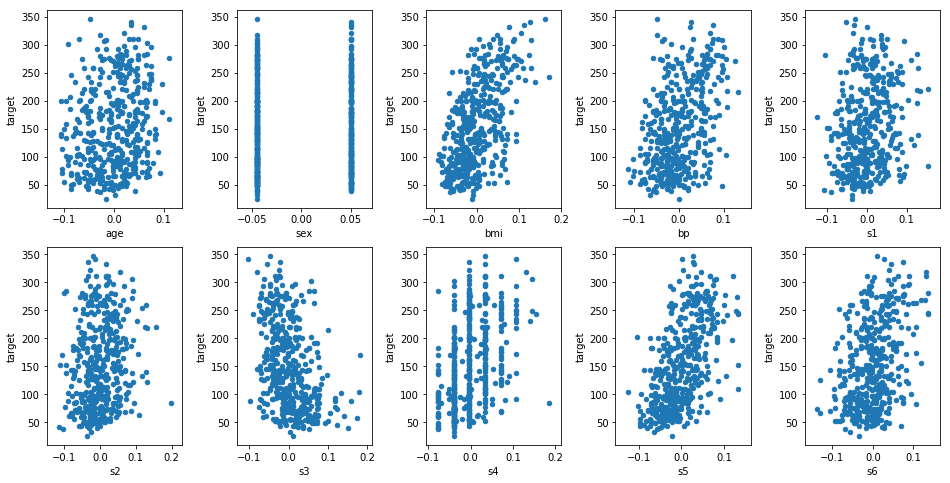

In [6]:
# データを可視化して分析する。
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
fig, axes = plt.subplots(2, 5, figsize=(16,8))
for key, ax in zip(df.keys(), axes.ravel()):
    df.plot(ax=ax, kind='scatter', x=key, y='target')

plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()
# bmi, s3, s5にtargetとの相関がありそう。

In [7]:
# データを分割する
# train_test_split関数：データの75%を訓練セットに、残り25%をテストセットに分割する。
# scikit-learnでは、データを大文字のXで、ラベルを小文字のyで示すのが一般的である。
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target,
random_state=0)

best_score_:  0.527902898728
best_params:  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 2}
test score:  0.362733231304


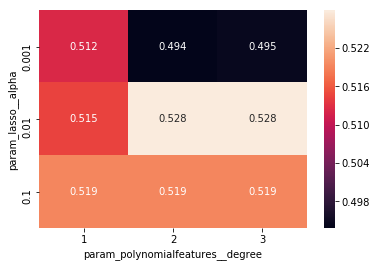

In [8]:
# 多項式特徴量 (PolynomialFeatures) + 線形モデル L1正則化 (Lasso)
# Lasso max_iter: パラメータ更新の繰り返し最大回数。
# alpha（後述）の値を小さくした場合は学習の収束までに必要なパラメータ更新回数
# が多くなるため、max_iterをデフォルト値の1000より大きくする必要がある。
pipe = make_pipeline(PolynomialFeatures(), Lasso(max_iter=100000))
# チューニング対象パラメータ
#   PolynomialFeatures degree: 多項式特徴量の次数
#   Lasso alpha: 正則化パラメータ。値が大きいほどモデルの係数が大きくなるのを強く抑制する。
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'lasso__alpha': [0.001, 0.01, 0.1]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('best_score_: ', grid.best_score_)
print('best_params: ', grid.best_params_)
print('test score: ', grid.score(X_test, y_test))
plot_heatmap_from_grid(grid)

best_score_:  0.524453646282
best_params_:  {'polynomialfeatures__degree': 3, 'ridge__alpha': 0.01}
test score:  0.366247197036


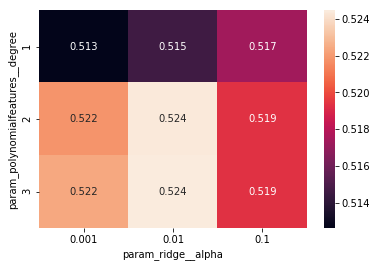

In [9]:
# 多項式特徴量 + 線形モデル L2正則化 (Ridge)
pipe = make_pipeline(PolynomialFeatures(), Ridge(max_iter=100000))
# チューニング対象パラメータ
#   PolynomialFeatures degree: 多項式特徴量の次数
#   Ridge alpha: 正則化パラメータ。値が大きいほどモデルの係数が大きくなるのを強く抑制する。
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('best_score_: ', grid.best_score_)
print('best_params_: ', grid.best_params_)
print('test score: ', grid.score(X_test, y_test))
plot_heatmap_from_grid(grid)

best_score_:  0.509514863965
best_params:  {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt'}
test score:  0.301299273427


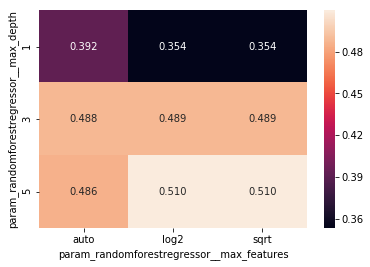

In [10]:
# ランダムフォレスト
# n_estimators: 構築する決定木の数。大きい方が頑健なモデルになるが計算量が増加する。
pipe = make_pipeline(RandomForestRegressor(n_estimators=100, random_state=0))
# チューニング対象パラメータ
# max_features: 各決定木に利用する特徴量の最大数
# max_depth: 各決定木の最大の深さ
# max_featuresとmax_depthは小さくすると過剰適合しにくくなるが、
# max_featuresが小さいときにmax_depthがを小さくし過ぎると適合不足になる。
param_grid = {'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [10, 5, 3, 1, None]}
param_grid = {'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [5, 3, 1]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('best_score_: ', grid.best_score_)
print('best_params: ', grid.best_params_)
print('test score: ', grid.score(X_test, y_test))
plot_heatmap_from_grid(grid)

best_score_:  0.506482547026
best_params:  {'svr__C': 1000, 'svr__epsilon': 10}
test score:  0.353230115014


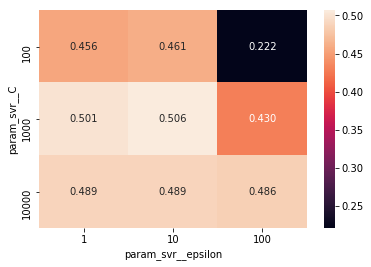

In [11]:
# サポートベクターマシン 線形カーネル (SVR kernel='linear')
pipe = make_pipeline(SVR(kernel='linear'))
# チューニング対象パラメータ
# C: 正則化パラメータ。値が大きいほどモデルの係数が大きくなるのを強く抑制する。
# epsilon: 正則化ペナルティを与えない回帰直（曲）線からの距離を決定する値。
param_grid = {'svr__C': [100, 1000, 10000], 'svr__epsilon': [1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('best_score_: ', grid.best_score_)
print('best_params: ', grid.best_params_)
print('test score: ', grid.score(X_test, y_test))
plot_heatmap_from_grid(grid)

best_score_:  0.502624272873
best_params:  {'svr__C': 100000, 'svr__epsilon': 10}
test score:  0.357268214488


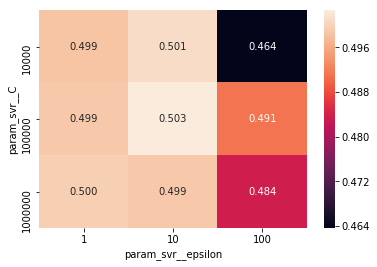

In [12]:
# サポートベクターマシン ガウシアンカーネル (SVR kernel='rbf')
pipe = make_pipeline(SVR(kernel='rbf'))
# チューニング対象パラメータ
# C: 正則化パラメータ。値が大きいほどモデルの係数が大きくなるのを強く抑制する。
# epsilon: 正則化ペナルティを与えない回帰直（曲）線からの距離を決定する値。
# ※ gammaは固定（1/特徴量数）とする。
param_grid = {'svr__C': [10000, 100000, 1000000], 'svr__epsilon': [1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print('best_score_: ', grid.best_score_)
print('best_params: ', grid.best_params_)
print('test score: ', grid.score(X_test, y_test))
plot_heatmap_from_grid(grid)